In [105]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib
import myutils
import my_models
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from IPython.display import display

In [106]:
SIZE = (28, 28)    # image resize
INPUT_SHAPE = (SIZE[0], SIZE[1], 1)  # input shape for CNNs
LR = 0.001    # learning rate
EPC = 10    # epochs

Original dataset consists of two folders, each with 15,000 images. I used the `ulimit -n` and `ls | shuf -n 1000 | xargs -I {} cp "{}" ~target/` command to randomly pick 1000 images from each folder. They are stored in `negative-samples` and `positive-samples`

Data obtained from https://www.kaggle.com/datasets/oluwaseunad/concrete-and-pavement-crack-images/code

In [107]:
d1, d2 = 'data/negative-samples', 'data/positive-samples'
negative_images, positive_images = [], []

filenames1 = os.listdir(d1)
for filename in filenames1:
    
    if filename.endswith(".jpg"):
            
            img = Image.open(os.path.join(d1, filename))
            
            # resize image to 128x128 pixels
            img = ImageOps.fit(img, SIZE, method=Image.LANCZOS)
            # grayscale image
            img = ImageOps.grayscale(img)
            
            negative_images.append(img)

filenames2 = os.listdir(d2)
for filename in filenames2:
    
    if filename.endswith(".jpg"):
            
            img = Image.open(os.path.join(d2, filename))
            img = ImageOps.fit(img, SIZE, method=Image.LANCZOS)
            img = ImageOps.grayscale(img)
            
            positive_images.append(img)

In [108]:
print(len(negative_images))
print(len(positive_images))

1000
1000


In [109]:
# shuffle the images
random.shuffle(negative_images)
random.shuffle(positive_images)

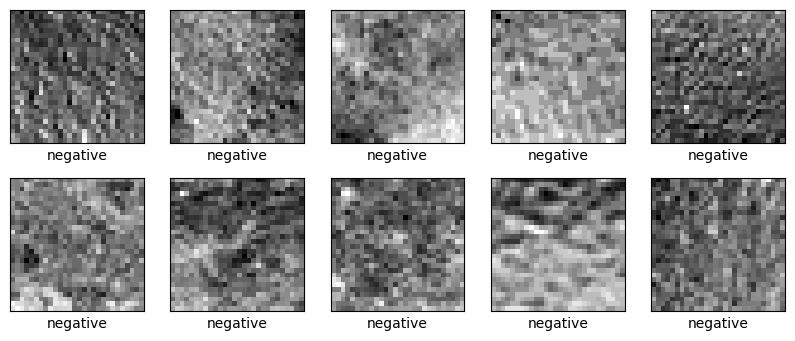

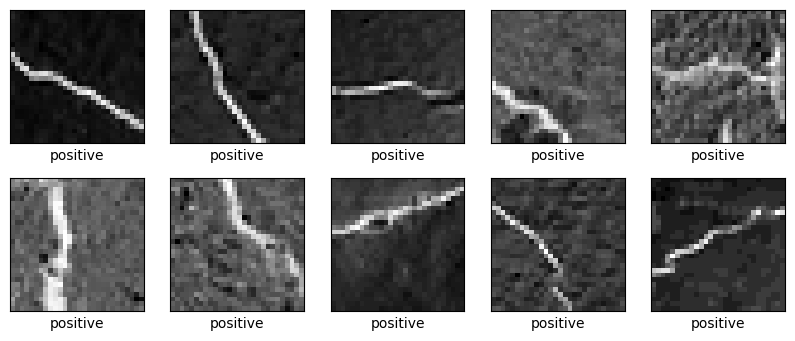

In [110]:
# display first 10 negative images
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(negative_images[i], cmap=plt.cm.binary)
    plt.xlabel("negative")
plt.show()
# display first 10 positive images
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(positive_images[i], cmap=plt.cm.binary)
    plt.xlabel("positive")
plt.show()

Now we turn these images into numpy arrays.

In [111]:
X_n = np.stack([np.array(img) for img in negative_images])
X_p = np.stack([np.array(img2) for img2 in positive_images])
X = np.vstack((X_n, X_p))
print("Shape of X:", X.shape)

# store data into array, where each element is [(0 or 1), (2d array of image)]
df = []
for i in range(2000):
    # first 1000 images are negative, and remaining 1000 images are positive
    if i < 1000:
        df.append([0, X[i]])
    else:
        df.append([1, X[i]])

# shuffle data
np.random.shuffle(df)
print("Lenght of df:", len(df))

Shape of X: (2000, 28, 28)
Lenght of df: 2000


X[0] shape: (28, 28)
y[0] = 1.0


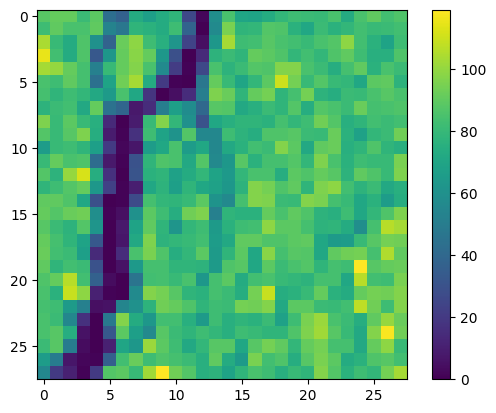

In [112]:
# separate df into X and y

X = np.zeros((2000, SIZE[0], SIZE[1]))
y = np.zeros((2000,))

for i in range(2000):
    y[i] = df[i][0]
    X[i] = df[i][1]

# take a look at sample 1
print("X[0] shape:", X[0].shape)
print("y[0] =", y[0])
plt.imshow(X[0])
plt.colorbar()

Scale the pixel values before training

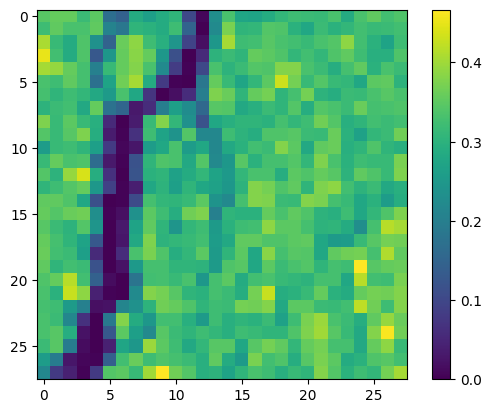

In [113]:
# scale pixel values
X = X / 255.0

plt.imshow(X[0])
plt.colorbar()

Split training data 60-20-20 (train, cv, test)

In [114]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
print("Dataset shapes: \n")
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X cv:", X_cv.shape)
print("y cv:", y_cv.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)

Dataset shapes: 

X train: (1200, 28, 28)
y train: (1200,)
X cv: (400, 28, 28)
y cv: (400,)
X test: (400, 28, 28)
y test: (400,)


In [115]:
# create model

tf.random.set_seed(42)
input_shape = (SIZE[0], SIZE[1], 1)

model = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
        
    ], name = "model1"
)

In [116]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, epochs=EPC, 
                    validation_data=(X_cv, y_cv))

Epoch 1/10
38/38 [==============================] - 1s 18ms/step - loss: 0.6901 - accuracy: 0.5217 - val_loss: 0.6798 - val_accuracy: 0.7650
Epoch 2/10
38/38 [==============================] - 0s 12ms/step - loss: 0.6015 - accuracy: 0.6733 - val_loss: 0.5018 - val_accuracy: 0.7975
Epoch 3/10
38/38 [==============================] - 0s 12ms/step - loss: 0.4496 - accuracy: 0.8100 - val_loss: 0.4776 - val_accuracy: 0.7725
Epoch 4/10
38/38 [==============================] - 0s 11ms/step - loss: 0.4499 - accuracy: 0.8025 - val_loss: 0.4294 - val_accuracy: 0.8250
Epoch 5/10
38/38 [==============================] - 0s 12ms/step - loss: 0.4065 - accuracy: 0.8333 - val_loss: 0.4353 - val_accuracy: 0.8400
Epoch 6/10
38/38 [==============================] - 0s 12ms/step - loss: 0.4069 - accuracy: 0.8275 - val_loss: 0.3909 - val_accuracy: 0.8325
Epoch 7/10
38/38 [==============================] - 0s 13ms/step - loss: 0.3789 - accuracy: 0.8450 - val_loss: 0.3886 - val_accuracy: 0.8525
Epoch 8/10
38

Evaluate model

Evaluation with cross-validation dataset:

loss = 0.3555019497871399
accuracy = 0.8475000262260437


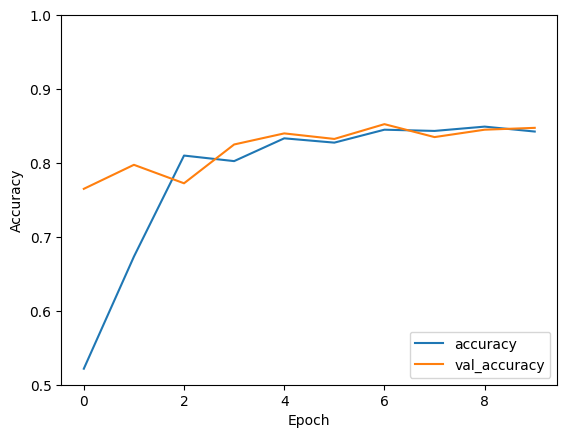

In [117]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print("Evaluation with cross-validation dataset:\n")
cv_loss, cv_acc = model.evaluate(X_cv, y_cv, verbose=0)
print(f"loss = {cv_loss}\naccuracy = {cv_acc}")

Hyperparameter Tuning

Lets try out different learning rates.

Cross validation metrics:

Learning rate = 0.1
	loss = 0.6984396576881409
	accuracy = 0.46000000834465027
Learning rate = 0.01
	loss = 0.3589324951171875
	accuracy = 0.8450000286102295
Learning rate = 0.001
	loss = 0.3555019497871399
	accuracy = 0.8475000262260437
Learning rate = 0.0001
	loss = 0.5006877779960632
	accuracy = 0.7950000166893005


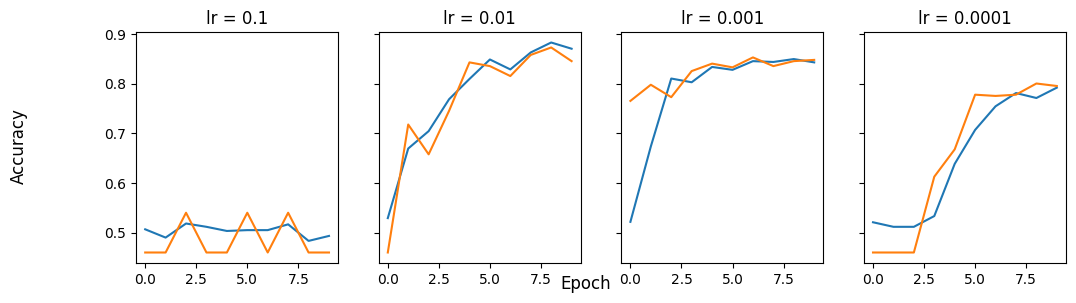

In [118]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]  # different learning rate values

fig, axes = plt.subplots(ncols=len(learning_rates), figsize=(12,3), sharey=True)
fig.supylabel('Accuracy')
fig.supxlabel('Epoch')

print("Cross validation metrics:\n")

for i, lr in enumerate(learning_rates):
    # reset the model
    model = myutils.create_model(INPUT_SHAPE)
    
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    history = model.fit(X_train, y_train, epochs=EPC, 
                        validation_data=(X_cv, y_cv), verbose=0)
    
    axes[i].set_title(f"lr = {lr}")
    axes[i].plot(history.history['accuracy'], label='accuracy')
    axes[i].plot(history.history['val_accuracy'], label = 'val_accuracy')

    cv_loss, cv_acc = model.evaluate(X_cv, y_cv, verbose=0)
    print("Learning rate =", lr)
    print(f"\tloss = {cv_loss}\n\taccuracy = {cv_acc}")
    

From here we can see that a learning rate of 0.01 is preferred.

In [119]:
LR = 0.01

For `LR = 0.01`, we can see that the model performs better in terms of accuracy. However, we also see that the curves oscillate heavily. This is a sign of overfitting. We will try out different models and regularization techniques to address this.

In [120]:
importlib.reload(my_models)  # reload the module so changes are applied 

mymodels = my_models.MyModels()

# this is the original model, call it model 1
model_1 = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_1", model_1)

# model 2
model_2 = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_2", model_2)

# TODO: I NEED TO CHOOSE A MODEL BEFORE TUNING. GOTTA MOVE THIS ENTIRE THING UP

mymodels.print_models()

['model_1', 'model_2']


In [121]:

------------------------------------------------------------------------------

SyntaxError: invalid syntax (626090593.py, line 1)

Let's try increasing the number of epochs.

Epoch 1/50
38/38 [==============================] - 1s 16ms/step - loss: 0.6872 - accuracy: 0.5433 - val_loss: 0.6594 - val_accuracy: 0.8200
Epoch 2/50
38/38 [==============================] - 0s 11ms/step - loss: 0.5778 - accuracy: 0.7492 - val_loss: 0.4874 - val_accuracy: 0.7700
Epoch 3/50
38/38 [==============================] - 0s 11ms/step - loss: 0.4853 - accuracy: 0.7883 - val_loss: 0.4193 - val_accuracy: 0.8275
Epoch 4/50
38/38 [==============================] - 0s 13ms/step - loss: 0.4418 - accuracy: 0.8125 - val_loss: 0.3968 - val_accuracy: 0.8625
Epoch 5/50
38/38 [==============================] - 0s 11ms/step - loss: 0.4270 - accuracy: 0.8233 - val_loss: 0.3710 - val_accuracy: 0.8375
Epoch 6/50
38/38 [==============================] - 0s 11ms/step - loss: 0.4170 - accuracy: 0.8250 - val_loss: 0.3807 - val_accuracy: 0.8700
Epoch 7/50
38/38 [==============================] - 0s 12ms/step - loss: 0.3929 - accuracy: 0.8383 - val_loss: 0.3597 - val_accuracy: 0.8375
Epoch 8/50
38

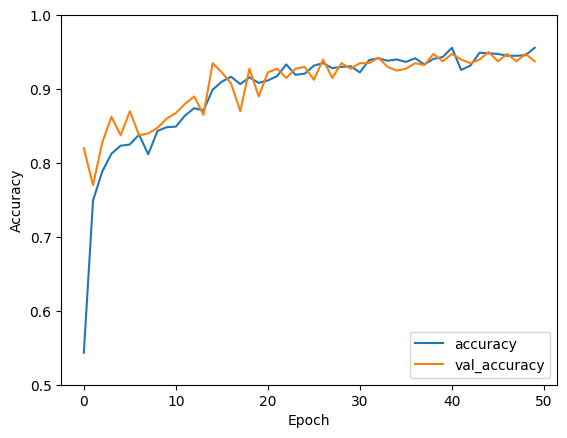

In [ ]:
EPC = 50    # used to be 10

# reset model
model = myutils.create_model(INPUT_SHAPE)

model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
        metrics=['accuracy']
    )
history = model.fit(X_train, y_train, epochs=EPC, validation_data=(X_cv, y_cv))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We can see that both `accuracy` and `val_accuracy` oscillates up and down. This indicates an overfitting of data. We will try regularization techniques

Ways to improve model:

- ! add/remove layers, increase/decrease neurons
- ! regularization like L1 or L2
- increase/decrease training data
- tuning hyperparameters like learning rate
- ! add dropout layers
- change image resolution?